<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Nougat/Inference_with_Nougat_to_read_scientific_PDFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with Nougat to read scientific PDFs

In this notebook, we'll perform inference with Nougat, a Donut model trained by Meta AI to transcribe scientific PDFs into a common Markdown format. Docs for Nougat can be found [here](https://huggingface.co/docs/transformers/main/en/model_doc/nougat).

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/nougat_architecture.jpg"
alt="drawing" width="600"/>

<small> Nougat high-level overview. Taken from the <a href="https://arxiv.org/abs/2308.13418">original paper</a>. </small>

## Set-up environment

Let's start by installing 🤗 Transformers and [pymupdf](https://github.com/pymupdf/PyMuPDF), a library which we can use to read PDFs as images. We install Transformers from source here since the model is brand new at the time of writing.

We also install Levenshtein and NLTK as those are required for postprocessing.

In [1]:
!pip install -q pymupdf python-Levenshtein nltk

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

## Load model and processor

Next, we instantiate the model and its processor from the hub.

In [3]:
from transformers import AutoProcessor, VisionEncoderDecoderModel
import torch

processor = AutoProcessor.from_pretrained("facebook/nougat-base")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-base")

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


We also move the model to the GPU if it's available. I used "capture" below to avoid printing the entire model.

In [4]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

## Load PDF

Below we load a sample PDF, and then use the fitz module to turn it into a list of Pillow images (one for each page).

In [5]:
from huggingface_hub import hf_hub_download

filepath = hf_hub_download(repo_id="ysharma/nougat", filename="input/nougat.pdf", repo_type="space")
print(filepath)

C:\Users\LENOVO\.cache\huggingface\hub\spaces--ysharma--nougat\snapshots\d06487a88e149a541a2803ea037f7a0bbd3b6c2c\input\nougat.pdf


In [6]:
from typing import Optional, List
import io
import fitz
from pathlib import Path

def rasterize_paper(
    pdf: Path,
    outpath: Optional[Path] = None,
    dpi: int = 96,
    return_pil=False,
    pages=None,
) -> Optional[List[io.BytesIO]]:
    """
    Rasterize a PDF file to PNG images.

    Args:
        pdf (Path): The path to the PDF file.
        outpath (Optional[Path], optional): The output directory. If None, the PIL images will be returned instead. Defaults to None.
        dpi (int, optional): The output DPI. Defaults to 96.
        return_pil (bool, optional): Whether to return the PIL images instead of writing them to disk. Defaults to False.
        pages (Optional[List[int]], optional): The pages to rasterize. If None, all pages will be rasterized. Defaults to None.

    Returns:
        Optional[List[io.BytesIO]]: The PIL images if `return_pil` is True, otherwise None.
    """

    pillow_images = []
    if outpath is None:
        return_pil = True
    try:
        if isinstance(pdf, (str, Path)):
            pdf = fitz.open(pdf)
        if pages is None:
            pages = range(len(pdf))
        for i in pages:
            page_bytes: bytes = pdf[i].get_pixmap(dpi=dpi).pil_tobytes(format="PNG")
            if return_pil:
                pillow_images.append(io.BytesIO(page_bytes))
            else:
                with (outpath / ("%02d.png" % (i + 1))).open("wb") as f:
                    f.write(page_bytes)
    except Exception:
        pass
    if return_pil:
        return pillow_images

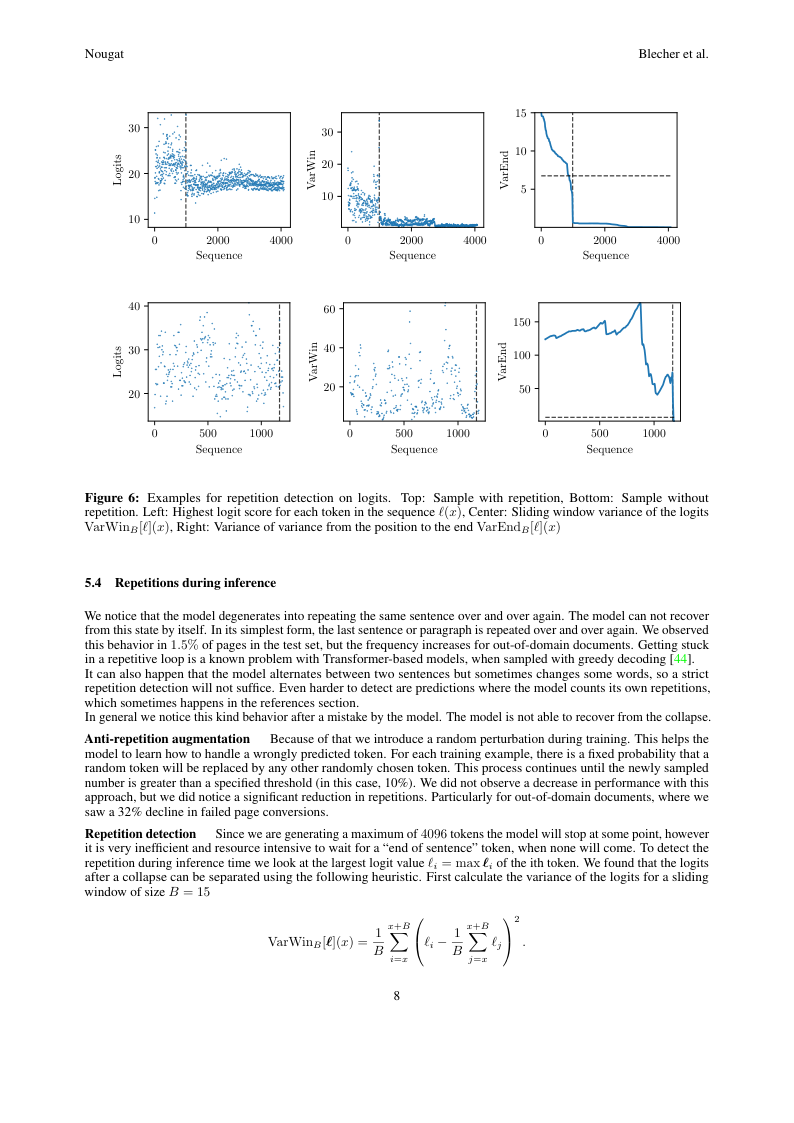

In [7]:
from PIL import Image

images = rasterize_paper(pdf=filepath, return_pil=True)
image = Image.open(images[7])
image

## Generate transcription

Next, we let the model autoregressively generate the text appearning in the PDF. This is a lot faster on GPU than on CPU.

The authors did define some custom `StoppingCriteria`(which determine when the model should stop generating), so we're going to use them here as well.

In [8]:
# prepare image for the model
pixel_values = processor(images=image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 896, 672])


In [9]:
from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)


class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0

In [10]:
# autoregressively generate tokens, with custom stopping criteria (as defined by the Nougat authors)
outputs = model.generate(pixel_values.to(device),
                          min_length=1,
                          max_length=3584,
                          bad_words_ids=[[processor.tokenizer.unk_token_id]],
                          return_dict_in_generate=True,
                          output_scores=True,
                          stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_105760\4023200142.py:23: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  return torch.var(self.values, 1) / self.values.shape[1]


## Postprocess

Finally we decode the generated IDs back to text and postprocess the generation.

In [11]:
generated = processor.batch_decode(outputs[0], skip_special_tokens=True)[0]
generated = processor.post_process_generation(generated, fix_markdown=False)
print(generated)



### Repetitions during inference

We notice that the model degenerates into repeating the same sentence over and over again. The model can not recover from this state by itself. In its simplest form, the last sentence or paragraph is repeated over and over again. We observed this behavior in \(1.5\%\) of pages in the test set, but the frequency increases for out-of-domain documents. Getting stuck in a repetitive loop is a known problem with Transformer-based models, when sampled with greedy decoding [44].

It can also happen that the model alternates between two sentences but sometimes changes some words, so a strict repetition detection will not suffice. Even harder to detect are predictions where the model counts its own repetitions, which sometimes happens in the references section.

In general we notice this kind behavior after a mistake by the model. The model is not able to recover from the collapse.

Anti-repetition augmentationBecause of that we introduce a random perturbatio

In [12]:
from IPython.display import Markdown, display
display(Markdown(generated))



### Repetitions during inference

We notice that the model degenerates into repeating the same sentence over and over again. The model can not recover from this state by itself. In its simplest form, the last sentence or paragraph is repeated over and over again. We observed this behavior in \(1.5\%\) of pages in the test set, but the frequency increases for out-of-domain documents. Getting stuck in a repetitive loop is a known problem with Transformer-based models, when sampled with greedy decoding [44].

It can also happen that the model alternates between two sentences but sometimes changes some words, so a strict repetition detection will not suffice. Even harder to detect are predictions where the model counts its own repetitions, which sometimes happens in the references section.

In general we notice this kind behavior after a mistake by the model. The model is not able to recover from the collapse.

Anti-repetition augmentationBecause of that we introduce a random perturbation during training. This helps the model to learn how to handle a wrongly predicted token. For each training example, there is a fixed probability that a random token will be replaced by any other randomly chosen token. This process continues until the newly sampled number is greater than a specified threshold (in this case, 10%). We did not observe a decrease in performance with this approach, but we did notice a significant reduction in repetitions. Particularly for out-of-domain documents, where we saw a 32% decline in failed page conversions.

Repetition detectionSince we are generating a maximum of \(4096\) tokens the model will stop at some point, however it is very inefficient and resource intensive to wait for a "end of sentence" token, when none will come. To detect the repetition during inference time we look at the largest logit value \(\ell_{i}=\max\bm{\ell}_{i}\) of the ith token. We found that the logits after a collapse can be separated using the following heuristic. First calculate the variance of the logits for a sliding window of size \(B=15\)

\[\mathrm{VarWin}_{B}[\bm{\ell}](x)=\frac{1}{B}\sum_{i=x}^{x+B}\left(\ell_{i}- \frac{1}{B}\sum_{j=x}^{x+B}\ell_{j}\right)^{2}.\]

Figure 6: Examples for repetition detection on logits. Top: Sample with repetition, Bottom: Sample without repetition. Left: Highest logit score for each token in the sequence \(\ell(x)\), Center: Sliding window variance of the logits \(\mathrm{VarWin}_{B}[\ell](x)\), Right: Variance of variance from the position to the end \(\mathrm{VarEnd}_{B}[\ell](x)\)